#### Libraries

In [1]:
!pip install numpy==1.19.3
!pip install mediapipe

     |████████████████████████████████| 14.9 MB 6.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 32.7 MB 190 kB/s 


In [3]:
import matplotlib.pyplot as plt
import mediapipe as mp
import pandas as pd
import numpy as np
import json
import cv2
import re
from google.colab.patches import cv2_imshow

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.optimizers import Nadam 

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#### Functions

In [18]:
def get_facelandmarks_video(video_path):
    #Read a set of frames from the video.
    video_frames = cv2.VideoCapture(video_path)
    video_length = int(video_frames.get(cv2.CAP_PROP_FRAME_COUNT))
    #Setup face mesh model object (there are several parameters pending for tuning up).
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    #Setup hand detector model.
    mp_hands = mp.solutions.hands
    hand_dect = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
    frame_hand_found, once, count = 0, 0, 0

    #Setup video saving properties.
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    #Output is prepared to receive input image rotated 90 degrees.
    out = cv2.VideoWriter('output.avi', fourcc, 30.0, (210,350))

    total_landmarks_video_x, total_landmarks_video_y, total_landmarks_video_z = [], [], []

    for frames in range(video_length-2):

        landmark_frame_x, landmark_frame_y, landmark_frame_z, = [], [], []
        #Read a frame from set of frames.
        ret, face_image = video_frames.read()
        #Resize to standard size (right size still pending to validate)
        face_image = cv2.resize(face_image, (350, 210), interpolation=cv2.INTER_AREA)
        #Rotate 90 degrees.
        rotate_image = cv2.rotate(face_image, cv2.cv2.ROTATE_90_CLOCKWISE)
        #Get height and width of image for further calculations ahead (defined above).
        height, width, _ = rotate_image.shape
        #Convert the BGR image to RGB (required by library).
        rgb_image = cv2.cvtColor(rotate_image, cv2.COLOR_BGR2RGB)
        #Get facial landmarks from the image:
        result = face_mesh.process(rgb_image)
        #Get hand from the image:
        result_hand = hand_dect.process(rgb_image)
        
        if (result_hand.multi_hand_landmarks) and (once == 0):
          frame_hand_found = count
          once = 1
        else:
          count = count + 1

       #If a Face has been recognized:
        if result.multi_face_landmarks:

          #Only one face, first element.
          facial_landmarks = result.multi_face_landmarks[0]
          #The models generate 468 normalized [x,y,z] facial landmarks. 
          for i in range(len(facial_landmarks.landmark)):
              #Denormalize: multiply X coordinate by width and Y coordinate by height.
              x = int(facial_landmarks.landmark[i].x * width)
              y = int(facial_landmarks.landmark[i].y * height)
              #Save tuple of normalized (x,y) coordinates.
              landmark_frame_x.append(facial_landmarks.landmark[i].x)
              landmark_frame_y.append(facial_landmarks.landmark[i].y)
              landmark_frame_z.append(facial_landmarks.landmark[i].z)
              #Attach denormalize facial landmarks to frame.
              cv2.circle(rotate_image,(x,y),2,(100,100,0),-1)
                          

          #Save each modified frame.  
          out.write(rotate_image)

          #Save lists of 468 facial landmarks from each frame.
          total_landmarks_video_x.append(landmark_frame_x)
          total_landmarks_video_y.append(landmark_frame_y)
          total_landmarks_video_z.append(landmark_frame_z)

        cv2.waitKey(1)

    #print("Number of Frames: ",len(total_landmarks_video_x))
    #print("Number of Total Facial LandMarks - X coordinate: ",len(total_landmarks_video_x)*len(total_landmarks_video_x[0]))
    #print("Number of Total Facial LandMarks - Y coordinate: ",len(total_landmarks_video_y)*len(total_landmarks_video_y[0]))
    
    return total_landmarks_video_x, total_landmarks_video_y, total_landmarks_video_z, frame_hand_found

In [4]:
# Generate multivariate features with window_size from parallel secuences.
def generate_input_time_slices(dataframe, window_cap_size, n_feature_values):
    x = []
    for i in range(len(dataframe.index)):
        end_step = i + window_cap_size
        out_end_ix = end_step + window_cap_size
        if out_end_ix > len(dataframe.index):
            break
        # Separate time feature values from time target values.
        x.append(dataframe.iloc[i:end_step, 0:n_feature_values].values)
        
    return np.array(x)

In [5]:
# Generate multivariate features with window_size from parallel sequences.
def generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample):
    coordinates = []
    i = 0
    while (i <= len(dataset_facelandmarks_x)-downsample-1):
        
        x_new, y_new, z_new = np.array(dataset_facelandmarks_x[i]), np.array(dataset_facelandmarks_y[i]), np.array(dataset_facelandmarks_z[i])
        
        for j in range(downsample-1):
            
            x_new = x_new + np.array(dataset_facelandmarks_x[(j+1)+i])
            y_new = y_new + np.array(dataset_facelandmarks_y[(j+1)+i])
            z_new = z_new + np.array(dataset_facelandmarks_z[(j+1)+i])
        
        i = i + downsample
        coordinates.append([x_new,y_new,z_new])
        
    return (np.array(coordinates)/downsample)

In [6]:
def normalize_capacitance_values(dataset_cap):

  min_max_scaler = preprocessing.MinMaxScaler()
  scaled_dataset = min_max_scaler.fit_transform(dataset_cap)
  scaled_dataset = pd.DataFrame(scaled_dataset)

  return scaled_dataset

In [7]:
# Split Train/Test dataset:
def split_train_test(x_time_features, y_time_targets):
    X_train, X_test, y_train, y_test = train_test_split(x_time_features, y_time_targets, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

#### FaceLandmarks Data Processing for Autoencoder: ####

In [8]:
from google.colab import files

uploaded = files.upload()

Saving IMG_2579.MOV to IMG_2579.MOV


In [ ]:
n_samples = 1
downsample = 1
total_instances = []

for i in range(n_samples):
    #Reading EXCEL file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    video_path = "Video_Face (" + file_number + ").MOV"
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
    # Generate train features and target from windowing process.
    instance = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    # If it is the first generation of time features.
    if (i == 0):
        total_instances = instance
    # If it is not the first generation of time features.
    else:
        total_instances = np.concatenate((total_instances, instance), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")
print("Total size of FaceLandMarks instances:", total_instances.shape)
print("Frame Synchronization:", frame_hand_found)

#Split Train and Test dataset:
#Transpose to shift dimension between coordinates and facelandsmark points.
total_instances_trans = total_instances.transpose(0,2,1)
total_instances_trans.shape
print("Shape of FaceLandMarks after Transpose(0,2,1):", total_instances_trans.shape)
#Get train and test data.
ratio_test = 0.3
test = total_instances_trans[:round(ratio_test*len(total_instances))-1]
train = total_instances_trans[round(ratio_test*len(total_instances)):len(total_instances)]
print("Shape of Train:", train.shape)
print("Shape of Test:", test.shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_input (InputLayer)   [(None, 468, 3)]          0         
                                                                 
 conv1d (Conv1D)             (None, 468, 10)           100       
                                                                 
 average_pooling1d (AverageP  (None, 234, 10)          0         
 ooling1D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 234, 10)          40        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 234, 10)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 234, 15)           465   

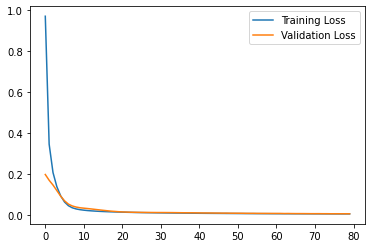

In [ ]:
#1D-CNN Autoencoder:

# Parameters:
dropoutrate = 0.2
kernel_size = 3
encoded_dim = 30

#Build Encoder.
encoder = Sequential([
    Conv1D(filters = 10, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "glorot_uniform", input_shape=(total_instances_trans.shape[1], total_instances_trans.shape[2])),
    AveragePooling1D(2),
    BatchNormalization(),
    Dropout(dropoutrate),
    Conv1D(filters = 15, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "glorot_uniform"),
    AveragePooling1D(2),
    BatchNormalization(),
    Dropout(dropoutrate),
    Conv1D(filters = 5, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "glorot_uniform"),
    Flatten(),
    Dense(encoded_dim, activation='relu', kernel_initializer = "glorot_uniform"),
])

#Build Decoder.
decoder = Sequential ([
    Dense(585, activation='relu', kernel_initializer = "glorot_uniform", input_shape=(encoded_dim,)),
    Reshape((117,5)),
    Conv1DTranspose(filters = 15, kernel_size = kernel_size, padding='same', activation='relu', kernel_initializer = "glorot_uniform"),
    UpSampling1D(2),
    BatchNormalization(),
    Conv1DTranspose(filters=10, kernel_size = kernel_size, activation='relu', padding='same', kernel_initializer = "glorot_uniform"),
    UpSampling1D(2),
    BatchNormalization(),
    Conv1DTranspose(filters=3, kernel_size = kernel_size, padding="same", kernel_initializer = "glorot_uniform")
])

#Merge models to Autoencoder.
conv_autoencoder = Model(inputs = encoder.inputs, outputs = decoder(encoder.outputs))
nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
conv_autoencoder.compile(optimizer=nadam, loss='mse')
conv_autoencoder.summary()
history = conv_autoencoder.fit(train, train, batch_size=32, epochs=80, validation_split=0.2)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.07494372065564293
X RMSE - Max: 0.28299557957910054

Y RMSE - Mean: 0.0716336664420782
Y RMSE - Max: 0.22602468893561692

Z RMSE - Mean: 0.059554943593785346
Z RMSE - Max: 0.26832281727225854



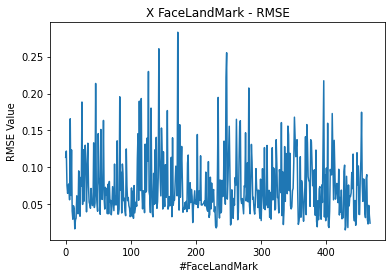

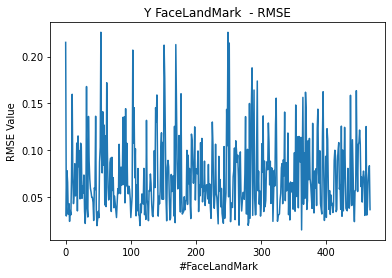

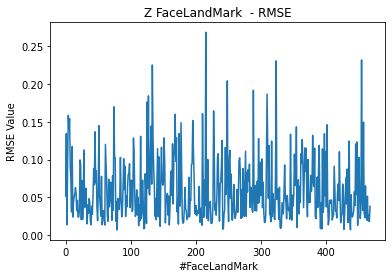

In [ ]:
#Calculate Test dataset RMSE
test_pred = conv_autoencoder.predict(test)

print("-------------------- Test Evaluation Results--------------------")
test_mae_loss = np.sqrt(np.mean(((test_pred - test)*(test_pred - test)), axis=0))

x_rmse = test_mae_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_mae_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")
z_rmse = test_mae_loss[:,2]
print("Z RMSE - Mean:", np.mean(z_rmse, axis=0))
print("Z RMSE - Max:", np.max(z_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

plt.title("Z FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,z_rmse) 
plt.show()

## Capacitive Data Processing for Regressor:

In [ ]:
n_samples = 2
downsample = 3
window_cap_size = 3
n_feature_values = 8
features_cap_timeslice = []
targets_facelandmark_timeslice = []

for i in range(n_samples):
    #Reading EXCEL file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "Capacitive_Values_FaceShield (" + file_number + ").xlsx"
    video_path = "Video_Face (" + file_number + ").MOV"
    # Read Excel file.
    dataset_cap = pd.read_excel(file_name_cap)
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    
    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
    #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(norm_dataset_cap, window_cap_size, n_feature_values)
    targets = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    
    #CHANGE:
    if (len(features)>len(targets)):
      features = features[0:len(targets)]
    else:
      targets = targets[0:len(features)]

    # If it is the first generation of time features.
    if (i == 0):
        total_features = features
        total_targets = targets
    # If it is not the first generation of time features.
    else:
        total_features = np.concatenate((total_features, features), axis=0)
        total_targets = np.concatenate((total_targets, targets), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")

print("Shape of Capacitive Data as Features:", total_features.shape)
print("Frame Synchronization:", frame_hand_found)
#Get the latent space features from the 468 Facelandmarks using the encoder from the trained autoencoder:
total_targets = total_targets.transpose(0,2,1)
total_enconded_target = encoder.predict(total_targets)
print("Shape of Encoded FaceLandMark points as Targets:", total_enconded_target.shape)

#Split Train and Test dataset:
X_train, X_test, y_train, y_test = split_train_test(total_features, total_enconded_target)

#Print results after Train/Test.
print("-------------------- Results after Train/Test Split --------------------")
print("Size of time features TRAIN data array:", X_train.shape)
print("Size of time features TEST data array:", X_test.shape)
print("Size of time target TRAIN data array:", y_train.shape)
print("Size of time target TEST data array:", y_test.shape)

Number of Cap samples in File #1:  284
Number of Frames in Video #1:  404
Number of Cap samples in File #2:  285
Number of Frames in Video #2:  816
-------------------- Features & Target Dimensions --------------------
Shape of Capacitive Data as Features: (405, 3, 8)
Shape of Encoded FaceLandMark points as Targets: (405, 30)
-------------------- Results after Train/Test Split --------------------
Size of time features TRAIN data array: (324, 3, 8)
Size of time features TEST data array: (81, 3, 8)
Size of time target TRAIN data array: (324, 30)
Size of time target TEST data array: (81, 30)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 2, 32)             544       
                                                                 
 batch_normalization_4 (Batc  (None, 2, 32)            128       
 hNormalization)                                                 
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 batch_normalization_5 (Batc  (None, 1, 32)            128       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 1, 32)             0         
                                                                 
 flatten_1 (Flatten)         (None, 32)               

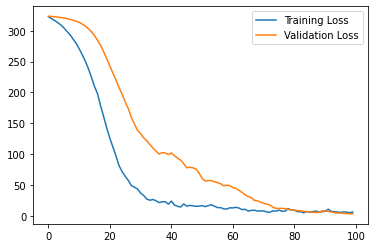

In [ ]:
#Prepare data for CNN model.
x_train = X_train
#n_output = enconded dimension.
n_output = y_train.shape[1]

#CNN:
# Parameters:
n_filters = 32
EPOCHS_CNN = 100

# Define architecture of CNN.
model_CNN = Sequential()
model_CNN.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "glorot_uniform", input_shape=(x_train.shape[1], x_train.shape[2])))
model_CNN.add(BatchNormalization())
model_CNN.add(Conv1D(filters=n_filters, kernel_size=2, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_CNN.add(Dropout(0.2))
#model_CNN.add(AveragePooling1D(2))
model_CNN.add(Flatten())
model_CNN.add(Dense(50, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_CNN.compile(loss='mse', optimizer=nadam, metrics=['mse'])
# Show summary of model.
model_CNN.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_CNN = model_CNN.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=EPOCHS_CNN)

plt.plot(history_CNN.history["loss"], label="Training Loss")
plt.plot(history_CNN.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

-------------------- Test Evaluation Results--------------------
Test RMSE 1D-CNN [2.0454464  0.16791472 4.166576   0.24875602 0.20039259 0.1924641
 0.24492805 3.6243773  0.18330364 3.2730649  0.16305645 2.0488796
 0.20150404 0.18236879 0.17900474 2.7271686  2.7684329  0.2586539
 2.6973915  0.15201524 1.9721633  2.1434748  0.25508624 2.758191
 0.15036441 3.6607885  3.5420291  0.1878456  0.20663397 0.16675791]

RMSE - Mean: 1.358968
RMSE - Max: 4.166576



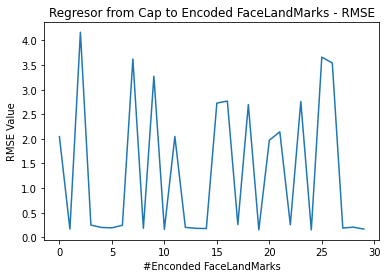

In [ ]:
#### Calculate Test dataset RMSE for 1D-CNN ####
test_pred = model_CNN.predict(X_test)

print("-------------------- Test Evaluation Results--------------------")
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))
print("Test RMSE 1D-CNN", test_rmse_loss)
print("")
print("RMSE - Mean:", np.mean(test_rmse_loss, axis=0))
print("RMSE - Max:", np.max(test_rmse_loss, axis=0))
print("")

enconder_dimension = np.array(list(range(0, len(test_rmse_loss))))
plt.title("Regresor from Cap to Encoded FaceLandMarks - RMSE") 
plt.xlabel("#Enconded FaceLandMarks") 
plt.ylabel("RMSE Value") 
plt.plot(enconder_dimension,test_rmse_loss) 
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 80)                2000      
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_5 (Dense)             (None, 60)                4860      
                                                                 
 dropout_4 (Dropout)         (None, 60)                0         
                                                                 
 dense_6 (Dense)             (None, 40)                2440      
                                                                 
 dense_7 (Dense)             (None, 30)                1230      
                                                                 
Total params: 10,530
Trainable params: 10,530
Non-trai

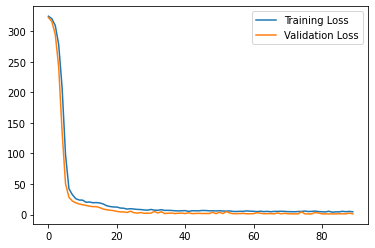

In [ ]:
#Prepare data for MLP model.
x_train = X_train
#Flaten train vector.
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
#n_output = enconded dimension.
n_output = y_train.shape[1]

EPOCHS_MLP = 90

model_MLP = Sequential()
model_MLP.add(Dense(80, activation='relu', input_dim=x_train.shape[1], kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(60, activation='relu', kernel_initializer = "glorot_uniform"))
model_CNN.add(BatchNormalization())
model_MLP.add(Dropout(0.2))
model_MLP.add(Dense(40, activation='relu', kernel_initializer = "glorot_uniform"))
model_MLP.add(Dense(n_output))

nadam = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model_MLP.compile(loss='mse', optimizer=nadam, metrics=['mse']) #incluir R2
# Show summary of model.
model_MLP.summary()
# Model weights are saved at the end of every epoch, if it's the best seen so far.
history_MLP = model_MLP.fit(x_train, y_train, batch_size=32, validation_split=0.20, epochs=EPOCHS_MLP)

plt.plot(history_MLP.history["loss"], label="Training Loss")
plt.plot(history_MLP.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

-------------------- Test Evaluation Results--------------------
Test RMSE MLP [1.5478071  0.03852339 2.5619366  0.2036708  0.08172349 0.09337531
 0.20123564 1.9346462  0.20827642 1.8526465  0.0540925  1.4531273
 0.14382336 0.14476378 0.1325059  1.6332796  2.3052928  0.09673843
 1.7348586  0.09195989 1.2598567  1.3430002  0.08795796 1.659027
 0.0392185  2.032196   2.171617   0.08176837 0.02041476 0.083889  ]

RMSE - Mean: 0.84310764
RMSE - Max: 2.5619366



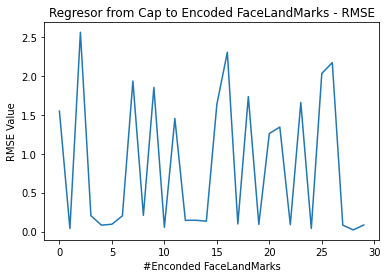

In [ ]:
#### Calculate Test dataset RMSE for MLP ####
x_test = X_test
#Flaten train vector.
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))
test_pred = model_MLP.predict(x_test)

print("-------------------- Test Evaluation Results--------------------")
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))
print("Test RMSE MLP", test_rmse_loss)
print("")
print("RMSE - Mean:", np.mean(test_rmse_loss, axis=0))
print("RMSE - Max:", np.max(test_rmse_loss, axis=0))
print("")

enconder_dimension = np.array(list(range(0, len(test_rmse_loss))))
plt.title("Regresor from Cap to Encoded FaceLandMarks - RMSE") 
plt.xlabel("#Enconded FaceLandMarks") 
plt.ylabel("RMSE Value") 
plt.plot(enconder_dimension,test_rmse_loss) 
plt.show()

## Complete Model Evaluation:

In [ ]:
n_test_sets = 4
downsample = 3
window_cap_size = 3
n_feature_values = 8
features_cap_timeslice = []
targets_facelandmark_timeslice = []

for i in range(n_samples):
    #Reading Excel file coming from SerialPort data:
    # Change name of file to read.
    file_number = str(i+1)
    file_name_cap = "Capacitive_Values_FaceShield_Test (" + file_number + ").xlsx"
    video_path = "Video_Face_Test (" + file_number + ").MOV"
    # Read Excel file.
    dataset_cap = pd.read_excel(file_name_cap)
    # Read FaceLandmarks from Video.
    dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, frame_hand_found = get_facelandmarks_video(video_path)
    
    print("Number of Cap samples in File #" + str(file_number) + ": ", len(dataset_cap))
    print("Number of Frames in Video #" + str(file_number) + ": ", len(dataset_facelandmarks_x))
    
   #Capacitive data channel Normalization.
    norm_dataset_cap = normalize_capacitance_values(dataset_cap)

    # Generate train features and target from windowing process.
    features = generate_input_time_slices(dataset_cap, window_cap_size, n_feature_values)
    targets = generate_output_time_slices(dataset_facelandmarks_x, dataset_facelandmarks_y, dataset_facelandmarks_z, downsample)
    
    #CHANGE (MISSING DATA SYNCHRONIZATION)
    if (len(features)>len(targets)):
      features = features[0:len(targets)]
    else:
      targets = targets[0:len(features)]

    # If it is the first generation of time features.
    if (i == 0):
        total_features = features
        total_targets = targets
    # If it is not the first generation of time features.
    else:
        total_features = np.concatenate((total_features, features), axis=0)
        total_targets = np.concatenate((total_targets, targets), axis=0)
          
print("-------------------- Features & Target Dimensions --------------------")
print("Frame Synchronization:", frame_hand_found)
print("Shape of Capacitive Data as Features:", total_features.shape)
print("Shape of Encoded FaceLandMark points as Targets:", total_targets.shape)

FileNotFoundError: ignored

-------------------- Test Evaluation Results--------------------
X RMSE - Mean: 0.1691618007827376
X RMSE - Max: 0.42562590853770854

Y RMSE - Mean: 0.17754446371286134
Y RMSE - Max: 0.4208393629948239

Z RMSE - Mean: 0.12002622584523912
Z RMSE - Max: 0.2728385327406171



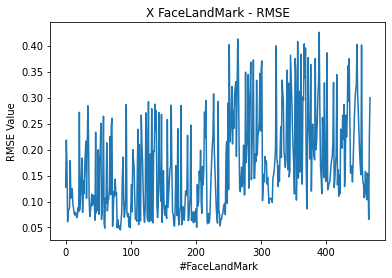

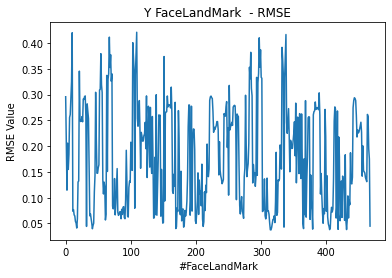

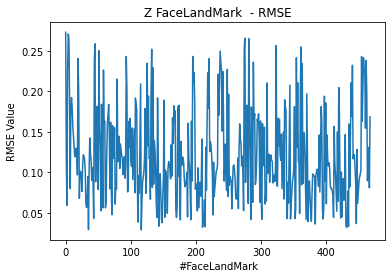

In [ ]:
#### Calculate Test RMSE for complete Model ####

#For MLP - Flaten features vector.
#Concatenate MLP Regressor and Decoder.
cap_face_model = Model(inputs = model_MLP.inputs, outputs = decoder(model_MLP.outputs))
x_test = total_features.reshape((total_features.shape[0], total_features.shape[1]*total_features.shape[2]))
y_test = total_targets

#For 1DCNN - Flaten features vector.
#Concatenate 1DCNN Regressor and Decoder.
cap_face_model = Model(inputs = model_CNN.inputs, outputs = decoder(model_CNN.outputs))
x_test = total_features
y_test = total_targets

#Compute predictions with complete model:
test_pred = cap_face_model.predict(x_test)

#Print evaluation results - RMSE:
print("-------------------- Test Evaluation Results--------------------")

#Calculate RMSE:
test_rmse_loss = np.sqrt(np.mean(((test_pred - y_test)*(test_pred - y_test)), axis=0))

x_rmse = test_rmse_loss[:,0]
print("X RMSE - Mean:", np.mean(x_rmse, axis=0))
print("X RMSE - Max:", np.max(x_rmse, axis=0))
print("")
y_rmse = test_rmse_loss[:,1]
print("Y RMSE - Mean:", np.mean(y_rmse, axis=0))
print("Y RMSE - Max:", np.max(y_rmse, axis=0))
print("")
z_rmse = test_rmse_loss[:,2]
print("Z RMSE - Mean:", np.mean(z_rmse, axis=0))
print("Z RMSE - Max:", np.max(z_rmse, axis=0))
print("")

facelandmarks = np.array(list(range(0, len(x_rmse))))

plt.title("X FaceLandMark - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,x_rmse) 
plt.show()

plt.title("Y FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,y_rmse) 
plt.show()

plt.title("Z FaceLandMark  - RMSE") 
plt.xlabel("#FaceLandMark") 
plt.ylabel("RMSE Value") 
plt.plot(facelandmarks,z_rmse) 
plt.show()

In [ ]:
#Help - References
#https://towardsdatascience.com/autoencoders-in-practice-dimensionality-reduction-and-image-denoising-ed9b9201e7e1